In [2]:
from __future__ import print_function
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_boston
from scipy.special import logsumexp
np.random.seed(0)

In [3]:
# load boston housing prices dataset
boston = load_boston()
x = boston['data']
N = x.shape[0]
x = np.concatenate((np.ones((506,1)),x),axis=1)
d = x.shape[1]
y = boston['target']
idx = np.random.permutation(range(N))

In [4]:
def l2(A, B):
    '''
    Input: A is a Nxd matrix
           B is a Mxd matirx
    Output: dist is a NxM matrix where dist[i,j] is the square norm between A[i,:] and B[j,:]
    i.e. dist[i,j] = ||A[i,:]-B[j,:]||^2
    '''
    A_norm = (A**2).sum(axis=1).reshape(A.shape[0],1)
    B_norm = (B**2).sum(axis=1).reshape(1,B.shape[0])
    dist = A_norm+B_norm-2*A.dot(B.transpose())
    return dist

def LRLS(test_datum, x_train, y_train, tau, lam=1e-5):
    '''
    Given a test datum, it returns its prediction based on locally weighted regression

    Input: test_datum is a dx1 test vector
           x_train is the N_train x d design matrix
           y_train is the N_train x 1 targets vector
           tau is the local reweighting parameter
           lam is the regularization parameter
    output is y_hat the prediction on test_datum
    '''
    l2_norms = l2(test_datum, x_train)
    predicted_y = np.array([])
    for i in range(test_datum.shape[0]):
        # obtaining the diagonal matrix A:
        Ai_denom = logsumexp([-l2_norms[i, j] / (2 * tau**2) for j in range(x_train.shape[0])])
        Ai_nums = [-l2_norms[i, j] / (2 * tau**2) for j in range(x_train.shape[0])]
        A = np.diag([np.exp(Ai_num - Ai_denom) for Ai_num in Ai_nums])

        # Obtaining the optimal weights/coefficients:
        a = x_train.transpose().dot(A).dot(x_train)
        a_regularized = a + np.identity(a.shape[0]) * lam
        b = x_train.transpose().dot(A).dot(y_train)
        w = np.linalg.solve(a_regularized, b)
        
        # computing y-hat
        predicted_y = np.append(predicted_y, test_datum[i].dot(w))
    return predicted_y


In [5]:
def run_on_fold(x_test, y_test, x_train, y_train, taus):
    '''
    Input: x_test is the N_test x d design matrix
           y_test is the N_test x 1 targets vector        
           x_train is the N_train x d design matrix
           y_train is the N_train x 1 targets vector
           taus is a vector of tau values to evaluate
    output: losses a vector of average losses one for each tau value
    '''
    losses = np.zeros(taus.shape)
    for j, tau in enumerate(taus):
        predicted_y = LRLS(x_test, x_train, y_train, tau)
        losses[j] = ((predicted_y - y_test) ** 2).mean()
    return losses

def run_k_fold(x, y, taus, k):
    """
    Input: x is the N x d design matrix
           y is the N x 1 targets vector    
           taus is a vector of tau values to evaluate
           K in the number of folds
    output is losses a vector of k-fold cross validation losses one for each tau value
    """
    losses = np.zeros((k, len(taus)))
    sub_sample_size = int(N/k)
    fold_indices = np.split(idx[:sub_sample_size * k], k)
    
    for i in range(k):
        # indices for the training data
        train_indices = np.delete(fold_indices, i, axis=0).flatten()
        # indices for the test data
        test_indices = fold_indices[i]
        
        x_test, y_test  = x[test_indices], y[test_indices]
        x_train, y_train  = x[train_indices], y[train_indices]
        loss = run_on_fold(x_test, y_test, x_train, y_train, taus)
        losses[i] = loss
    
    return losses.mean(0)

In [6]:
taus = np.logspace(1.0, 3, 200)
losses = run_k_fold(x, y, taus, k=5)

min loss = 11.985449580854745


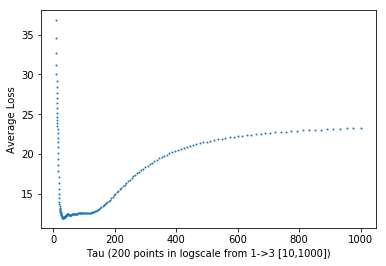

In [7]:
plt.scatter(x=taus, y=losses, s=1)
plt.ylabel("Average Loss")
plt.xlabel("Tau (200 points in logscale from 1->3 [10,1000])")
print("min loss = {}".format(losses.min()))